# Data Loading

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_id = '1affGFPxQ1RmV73Vk7tDNaDSbUWP4YDHP'
destination = 'texas.json'
download_file_from_google_drive(file_id, destination)

In [ ]:
import json
with open('texas.json', 'r') as fp:
    texas = json.load(fp)

In [ ]:
texas[0].keys()

dict_keys(['C1', 'C2', 'M1', 'M2'])

In [ ]:
comment_vocab = set()
code_vocab = set()
for sample in texas:
  comment_vocab |= set(sample['C1']) | set(sample['C2'])
  code_vocab |= set(sample['M1']) | set(sample['M2'])
print(len(comment_vocab), len(code_vocab))

3780 5632


In [ ]:
texas[0]

{'C1': ['crash',
  'report',
  'data',
  'read',
  'from',
  'the',
  'supplied',
  'input',
  'stream'],
 'C2': ['crash', 'report', 'data', 'read', 'from', 'the', 'supplied', 'file'],
 'M1': ['non',
  'public',
  'crash',
  'report',
  'data',
  'load',
  'non',
  'file',
  'file',
  'throws',
  'ioexception',
  'final',
  'input',
  'stream',
  'in',
  'new',
  'buffered',
  'input',
  'stream',
  'new',
  'file',
  'input',
  'stream',
  'file',
  'acraconstants',
  'default',
  'buffer',
  'size',
  'in',
  'bytes',
  'try',
  'return',
  'load',
  'new',
  'input',
  'stream',
  'reader',
  'in',
  'str',
  'finally',
  'ioutils',
  'safe',
  'close',
  'in'],
 'M2': ['non',
  'public',
  'crash',
  'report',
  'data',
  'load',
  'non',
  'file',
  'file',
  'throws',
  'ioexception',
  'jsonexception',
  'final',
  'input',
  'stream',
  'in',
  'new',
  'buffered',
  'input',
  'stream',
  'new',
  'file',
  'input',
  'stream',
  'file',
  'acraconstants',
  'default',
  'buff

In [ ]:
"public" in code_vocab

True

In [ ]:
# c - token in comment, m - token im method
def id2c(id):
  return list(comment_vocab)[id]

c2id = {c: id for id, c in enumerate(comment_vocab)}

In [ ]:
def id2m(id):
  return list(code_vocab)[id]

m2id = {m: id for id, m in enumerate(code_vocab)}

In [ ]:
def tokens_to_ids(tokens, is_c):
  if is_c:
    return [c2id[c] for c in tokens]
  else:
    return [m2id[m] for m in tokens]
def ids_to_tokens(ids, is_c):
  if is_c:
    return [id2c(id) for id in ids]
  else:
    return [id2m(id) for id in ids]

In [ ]:
ids_to_tokens(tokens_to_ids(['if', 'else', 'print'], False), False)

['if', 'else', 'print']

In [ ]:
import tensorflow as tf

In [ ]:
def create_dataset(data):
  cX, mX = [], []
  Y = []
  for sample in data:
    C1 = tokens_to_ids(sample['C1'], is_c=True)
    C2 = tokens_to_ids(sample['C2'], is_c=True)
    M1 = tokens_to_ids(sample['M1'], is_c=False)
    M2 = tokens_to_ids(sample['M2'], is_c=False)
    # New code and old comment --> inconsistency 
    cX.append(C1)
    mX.append(M2)
    Y.append(1)
    # New code and new comment --> consistency
    cX.append(C2)
    mX.append(M2)
    Y.append(0)
  return cX, mX, Y

In [ ]:
cX, mX, Y = create_dataset(texas)

In [ ]:
from sklearn.model_selection import train_test_split
cX_train, cX_test, mX_train, mX_test, Y_train, Y_test = train_test_split(cX, mX, Y, test_size=0.2)

In [ ]:
# PAD sequences to max len
PAD_m = len(code_vocab)
PAD_c = len(comment_vocab)
max(map(len, cX_train)), max(map(len, mX_train)) 

(109, 972)

In [ ]:
cX_train = tf.keras.preprocessing.sequence.pad_sequences(cX_train, value=PAD_c, padding='post')
mX_train = tf.keras.preprocessing.sequence.pad_sequences(mX_train, value=PAD_m, padding='post')

In [ ]:
cX_test = tf.keras.preprocessing.sequence.pad_sequences(cX_test, value=PAD_c, padding='post')
mX_test = tf.keras.preprocessing.sequence.pad_sequences(mX_test, value=PAD_m, padding='post')

In [ ]:
import numpy as np
np.array(cX_train).shape

(5230, 109)

In [ ]:
def sample_data(cX, mX, Y, k = 5):
  for _ in range(k):
    id = np.random.randint(0, len(Y))
    C = cX[id]
    M = mX[id]
    C = list(filter(lambda x: x != PAD_c, C))
    C = list(map(lambda x: id2c(x), C))
    M = list(filter(lambda x: x != PAD_m, M))
    M = list(map(lambda x: id2m(x), M))
    print(f"C: {' '.join(C)} \n M: {' '.join(M)} \n {'Inconsistent' if Y[id] else 'Consistent'}")
sample_data(cX_train, mX_train, Y_train)

C: a method delegation implementation to the given instance methods 
 M: public method delegation to object target type type return to target type method graph compiler default 
 Inconsistent
C: formatted value formats time in ms and appends difference finish time start time as returned by format time diff if finish time is empty string is returned if start time is then difference is not appended to return value 
 M: deprecated public static string get formatted time with diff date format date format long finish time long start time string formatted finish time date format format finish time return get formatted time with diff formatted finish time finish time start time 
 Consistent
C: the resulting char sequence 
 M: public static string replace first char sequence self pattern pattern char sequence replacement return pattern matcher self replace first replacement to string 
 Inconsistent
C: the signature of the lambda 
 M: public static try method type get lambda signature serializa

# Average em. 

In [ ]:
from tensorflow.keras import layers
m_vocab_size = len(code_vocab)
c_vocab_size = len(comment_vocab) 
embedding_size = 128

code_input = tf.keras.Input((None,), name='code')
comment_input = tf.keras.Input((None, ), name='comment')

code_features = layers.Embedding(input_dim=m_vocab_size + 1,
                                output_dim=embedding_size)(code_input)

comment_features = layers.Embedding(input_dim=c_vocab_size + 1,
                                output_dim=embedding_size)(comment_input)

dropout_rate = 0.2
code_features_d = layers.Dropout(dropout_rate)(code_features)

code_encoder = layers.GlobalAveragePooling1D()(code_features_d)

comment_features_d = layers.Dropout(dropout_rate)(comment_features)

comment_encoder = layers.GlobalAveragePooling1D()(comment_features_d)

encoder = layers.Concatenate()([code_encoder, comment_encoder])

#encoder_d = layers.Dropout(dropout_rate)(encoder)
output = layers.Dense(1, name='out', activation='sigmoid')(encoder)

model = tf.keras.Model(inputs=[code_input, comment_input],
                        outputs=[output])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
code (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
comment (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    721024      code[0][0]                       
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    483968      comment[0][0]                    
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras import losses
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics='accuracy')

In [ ]:
epochs = 10
history = model.fit(
    x={'code': np.array(mX_train), 'comment': np.array(cX_train)}, 
    y={'out': np.array(Y_train)},
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/10
131/131 [==============================] - 3s 21ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4924
Epoch 2/10
131/131 [==============================] - 3s 21ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4924
Epoch 3/10
131/131 [==============================] - 3s 21ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4924
Epoch 4/10
131/131 [==============================] - 3s 21ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4924
Epoch 5/10
131/131 [==============================] - 3s 21ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4924
Epoch 6/10
131/131 [==============================] - 3s 21ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4924
Epoch 7/10
131/131 [==============================] - 3s 21ms/step - loss: 0.6931 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4924

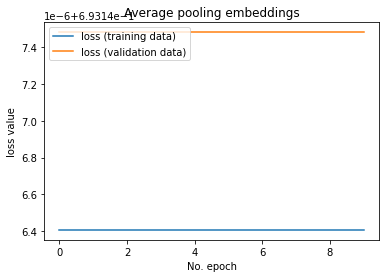

In [ ]:
# Plot history: MAE
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss (training data)')
plt.plot(history.history['val_loss'], label='loss (validation data)')
plt.title('Average pooling embeddings')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate({'code': np.array(mX_test), 'comment': np.array(cX_test)}, {'out': np.array(Y_test)})
print("test loss, test acc:", results)

Evaluate on test data
41/41 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4992
test loss, test acc: [0.6931475400924683, 0.49923548102378845]


In [ ]:
int(len(cX_test))

1308

# TF-IDF

In [ ]:
# Example of TF-IDF transformation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

corpus = [
     ['this', 'is', 'the', 'first', 'document', 'document'],
     ['this', 'is', 'the', 'second', 'document'],
     ['this', 'is', 'the', 'third', 'document', 'document']
    ]
vectorizer = TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, use_idf=True, sublinear_tf=True, norm='l2')
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X)

['document', 'first', 'is', 'second', 'the', 'third', 'this']
  (0, 0)	0.5729288343964706
  (0, 1)	0.5729288343964706
  (0, 4)	0.3383809989908826
  (0, 2)	0.3383809989908826
  (0, 6)	0.3383809989908826
  (1, 3)	0.6461289150464732
  (1, 0)	0.3816141458138271
  (1, 4)	0.3816141458138271
  (1, 2)	0.3816141458138271
  (1, 6)	0.3816141458138271
  (2, 5)	0.5729288343964706
  (2, 0)	0.5729288343964706
  (2, 4)	0.3383809989908826
  (2, 2)	0.3383809989908826
  (2, 6)	0.3383809989908826


In [ ]:
# Example of TF-IDF transformation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

def create_translator(is_code):
  def tf_idf_tokenizer(ids):
    tokens = []
    for id in ids:
      if is_code and id == PAD_m:
        tokens.append('<PAD>')
      elif not is_code and id == PAD_c:
        tokens.append('<PAD>')
      else:
        if is_code:
          tokens.append(id2m(id))
        else:
          tokens.append(id2c(id))
    return tokens
  return tf_idf_tokenizer

corpus = [
     cX_train[0],
     cX_train[1],
    ]

vectorizer = TfidfVectorizer(max_features=1500, tokenizer=create_translator(False), lowercase=False, use_idf=True, sublinear_tf=True, norm='l2')
tf_cX = vectorizer.fit_transform(cX)

In [ ]:
vectorizer = TfidfVectorizer(max_features=3000, tokenizer=create_translator(True), lowercase=False, use_idf=True, sublinear_tf=True, norm='l2')
tf_mX = vectorizer.fit_transform(mX)

In [ ]:
tf_X = np.hstack((np.array(tf_cX.toarray()), np.array(tf_mX.toarray())))

In [ ]:
tf_X.shape

(6538, 4500)

In [ ]:
tf_X_train, tf_X_test, tf_Y_train, tf_Y_test, tf_ids_train, tf_ids_test = train_test_split(
    tf_X, 
    Y, 
    list(range(tf_X.shape[0])), test_size=.2, random_state=23)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

clf = SVC(random_state=1, kernel='linear', C=1e8)
clf.fit(tf_X_train, tf_Y_train)
y_pred = clf.predict(tf_X_test)

#print('Mean Accuracy on Test set: %.3f' %  (clf.score(tf_X_test, tf_Y_test)))
print('Calculating F1-Score on Prediction: ', f1_score(tf_Y_test, y_pred,  average='binary'))
print('Calculating F1-MacroAverage-Score on Prediction: ', f1_score(tf_Y_test, y_pred,  average='macro'))
print('Calculating RocAUC on Prediction: ', roc_auc_score(tf_Y_test, y_pred,  average='macro'))
#classify_samples(pipe_svc, param_grid, f1_score, scoring='f1',)

In [ ]:
clf.dual_coef_

array([[-2.05885888, -1.26802272, -2.54055169, ...,  5.94274887,
         3.0323873 ,  2.51175123]])

In [ ]:
print('Mean Accuracy on Test set: %.3f' %  (clf.score(tf_X_train, tf_Y_train)))
